In [11]:
import os

print("Current Working Directory:", os.getcwd())
# If necessary, change it to the root of your project (adjust the path as needed)
os.chdir("e:\Documentos\Thesis_Master\Master")
print("New Working Directory:", os.getcwd())

Current Working Directory: e:\Documentos\Thesis_Master\Master\src
New Working Directory: e:\Documentos\Thesis_Master\Master


In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from shapely.geometry import Polygon, Point
from src.utils.interpolation import vector_interpolation
from src.utils.intersection import generate_intersection_registry

In [62]:
# Example curve
theta = np.linspace(0, 2 * np.pi, 100)
curve = ((1.0) * np.array([np.cos(theta), np.sin(theta)])).T
curve_polygon = Polygon(curve)

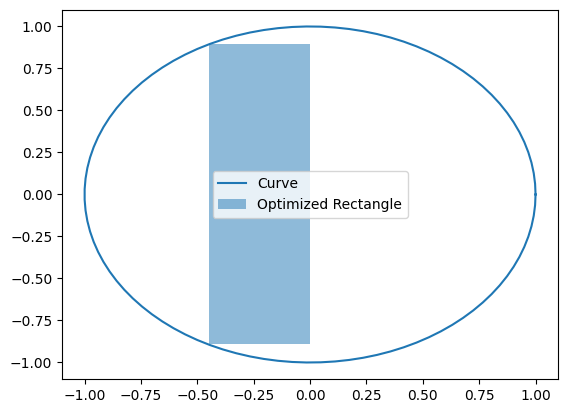

In [107]:

x_max, y_max = np.max(curve, axis=0)
x_min, y_min = np.min(curve, axis=0)

delta_y = y_max - y_min

a = 0.0
b = -0.45

registry = generate_intersection_registry(
    np.array(
        [
            [a, y_min - delta_y],
            [a, y_max + delta_y],
            [b, y_max + delta_y],
            [b, y_min - delta_y],
        ]
    ),
    curve,
)

intersections = registry.get_intersections("a0") + registry.get_intersections("a2")
# Assuming intersections is your list of dictionaries
sorted_intersections = sorted(
    intersections,
    key=lambda x: (x["intersection_point"][0], x["intersection_point"][1]),
)

#Determine the corners of the torsion box
box_corners = np.array([intersect_data["intersection_point"] for intersect_data in sorted_intersections])
bc_x, bc_y = np.max(box_corners[[0,2]], axis= 0) # bottom corner
tc_x, tc_y = np.min(box_corners[[1, 3]], axis=0) # top corner

bottom_corner = np.array([a, bc_y])
top_corner = np.array([b, tc_y])
# Now, sorted_intersections is sorted first by the x-coordinate and then by t

# Plotting for visualization
x, y = bottom_corner
width, height = top_corner - bottom_corner
fig, ax = plt.subplots()
ax.plot(curve[:, 0], curve[:, 1], label="Curve")
rectangle = Polygon([(x, y), (x + width, y), (x + width, y + height), (x, y + height)])
x, y = rectangle.exterior.xy
ax.fill(x, y, alpha=0.5, label="Optimized Rectangle")
ax.legend()
plt.show()

Optimized rectangle parameters (x, y, width, height): (-0.6546887504422315, -0.7558892962515213, 1.3086194308223749, 1.5117785925030427)
Maximized second moment of inertia: 0.6034930513181574


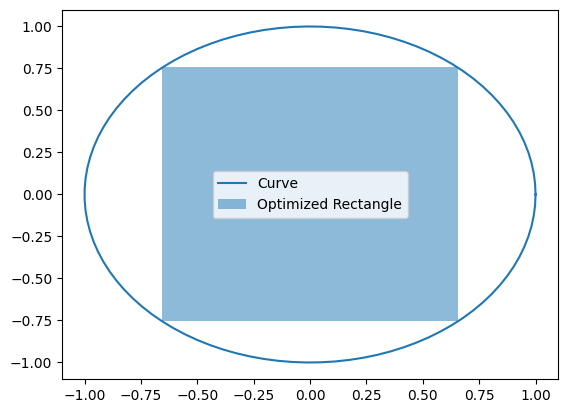

: 

In [128]:
x_max, y_max = np.max(curve, axis=0)
x_min, y_min = np.min(curve, axis=0)

delta_x = x_max - x_min
delta_y = y_max - y_min

def get_embedded_rectangle(a, b):

    registry = generate_intersection_registry(
        np.array(
            [
                [a, y_min - delta_y],
                [a, y_max + delta_y],
                [b, y_max + delta_y],
                [b, y_min - delta_y],
            ]
        ),
        curve,
    )

    intersections = registry.get_intersections("a0") + registry.get_intersections("a2")
    # Assuming intersections is your list of dictionaries
    sorted_intersections = sorted(
        intersections,
        key=lambda x: (x["intersection_point"][0], x["intersection_point"][1]),
    )

    # Determine the corners of the torsion box
    box_corners = np.array(
        [intersect_data["intersection_point"] for intersect_data in sorted_intersections]
    )

    bc_x, bc_y = np.max(box_corners[[0, 2]], axis=0)  # bottom corner
    tc_x, tc_y = np.min(box_corners[[1, 3]], axis=0)  # top corner

    bottom_corner = np.array([a, bc_y])
    top_corner = np.array([b, tc_y])
    # Now, sorted_intersections is sorted first by the x-coordinate and then by t

    # Plotting for visualization
    x, y = bottom_corner
    width, height = top_corner - bottom_corner

    return x, y, width, height


def second_moment_of_inertia(width, height):
    """Calculate the second moment of inertia of the rectangle."""
    return np.array([(1 / 12) * width * height**3 , (1 / 12) * height * width**3])


def objective(params):
    """Objective function to maximize the second moment of inertia."""
    weights = np.array([0.4, 0.2, 0.6])
    x1, x2, thickness = params
    x, y, width, height = get_embedded_rectangle(x1, x2)

    b = width - 2 * thickness
    h = height - 2 * thickness

    Ixx, Iyy = second_moment_of_inertia(width, height) - second_moment_of_inertia(b, h)
    area = height * width - b * h

    J0 = Ixx + Iyy

    metric = weights[0] * Ixx + weights[1] * Iyy + weights[2] * J0
    metric = metric / area

    return -metric  # Negative because we want to maximize


# Initial guess (x, y, width, height)
initial_guess = [-0.1, 0.1, 0.0003]

margin = 0.15

x_bounds = (x_min + (margin * delta_x), x_max - (margin * delta_x))

# Bounds for (x, y, width, height)
bounds = [x_bounds, x_bounds, (0.0003, 0.001)]

# Optimization
result = minimize(objective, x0=initial_guess, bounds=bounds)  # , constraints=cons

if result.success:
    optimized_params = result.x
    x0, x1, thickness = optimized_params
    
    x, y, width, height = get_embedded_rectangle(x0, x1)
    print(
        f"Optimized rectangle parameters (x, y, width, height): {x, y, width, height}"
    )
    print(f"Maximized second moment of inertia: {-result.fun}")

    # Plotting for visualization
    fig, ax = plt.subplots()
    ax.plot(curve[:, 0], curve[:, 1], label="Curve")
    rectangle = Polygon(
        [(x, y), (x + width, y), (x + width, y + height), (x, y + height)]
    )
    x, y = rectangle.exterior.xy
    ax.fill(x, y, alpha=0.5, label="Optimized Rectangle")
    ax.legend()
    plt.show()
else:
    print("Optimization failed.")

-0.85 0.8580968837841148
[[-0.85       -0.52609983]
 [-0.85        0.52609983]
 [ 0.85809688 -0.51250776]
 [ 0.85809688  0.51250776]]
Optimized rectangle parameters (x, y, width, height): (-0.85, -0.5125077596687877, 1.7080968837841146, 1.025015519337575)
Maximized second moment of inertia: 0.13610705187398256


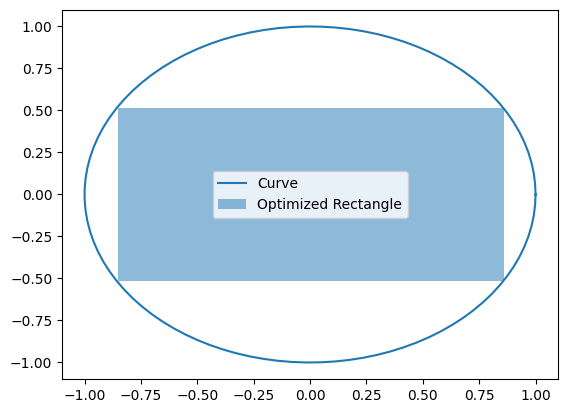

In [120]:
x0, x1 = -0.85, 0.8580968837841148
x, y, width, height = get_embedded_rectangle(x0, x1)
print(
    f"Optimized rectangle parameters (x, y, width, height): {x, y, width, height}"
)
print(f"Maximized second moment of inertia: {-result.fun}")

# Plotting for visualization
fig, ax = plt.subplots()
ax.plot(curve[:, 0], curve[:, 1], label="Curve")
rectangle = Polygon(
    [(x, y), (x + width, y), (x + width, y + height), (x, y + height)]
)
x, y = rectangle.exterior.xy
ax.fill(x, y, alpha=0.5, label="Optimized Rectangle")
ax.legend()
plt.show()

In [123]:
x_min, y_min = np.min(curve, axis=0)
x_min, y_min


(-0.9994965423831851, -0.9998741276738751)

In [106]:
box_corners

array([[-0.45      , -0.89281474],
       [-0.45      ,  0.89281474],
       [ 0.        , -0.99962237],
       [ 0.        ,  0.99962237]])

In [63]:
xp = np.arange(len(curve))/(len(curve)-1)
points = vector_interpolation(np.array([0,0.5]), xp, curve)
print(points)
width, height = np.abs(np.diff(points, axis=0)).flatten()
x, y = np.min(points, axis=0)

np.min(points, axis = 0)

points




[[ 1.00000000e+00  0.00000000e+00]
 [-9.99496542e-01 -9.71445147e-17]]


array([-9.99496542e-01, -9.71445147e-17])

Optimized rectangle parameters (x, y, width, height): [1.21212119e-01 6.26262598e-01 3.00000000e-04]
Maximized second moment of inertia: 1.1991134863576847


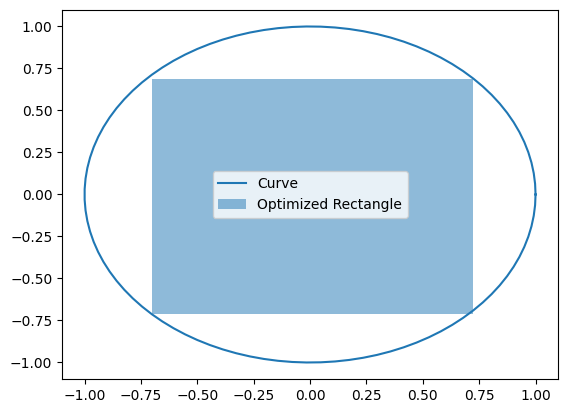

In [65]:
def is_rectangle_inside(array):
    """Check if the rectangle is inside the curve."""
    t1, t2, thickness = array
    n = len(curve)
    xp = np.arange(n) / (n - 1)
    points = vector_interpolation(np.array([t1, t2]), xp, curve)
    x, y = np.min(points, axis=0)
    width, height = np.abs(np.diff(points, axis=0)).flatten()

    rectangle = Polygon(
        [(x, y), (x + width, y), (x + width, y + height), (x, y + height)]
    )
    return float(curve_polygon.contains(rectangle)) - 1 


def second_moment_of_inertia(width, height):
    """Calculate the second moment of inertia of the rectangle."""
    return (1 / 12) * width * height**3 + (1 / 12) * height * width**3


def objective(params):
    """Objective function to maximize the second moment of inertia."""
    weights = np.array([0.4, 0.2, 0.6])
    t1, t2, thickness = params
    n = len(curve)
    xp = np.arange(n)/(n-1)
    points = vector_interpolation(np.array([t1, t2]), xp, curve)
    width, height = np.abs(np.diff(points, axis=0)).flatten()

    b = width -2 *thickness
    h = height - 2 * thickness

    Ixx = second_moment_of_inertia(width, height) - second_moment_of_inertia(
        b, h
    )
    area = height * width - b * h

    Iyy = second_moment_of_inertia(height, width) - second_moment_of_inertia(h, b)

    J0 = Ixx + Iyy

    metric = weights[0] * Ixx + weights[1] * Iyy + weights[2] * J0
    metric = metric/area

    return -metric  # Negative because we want to maximize


# Initial guess (x, y, width, height)
initial_guess = [0.1, 0.3, 0.0003]

constraint = {"type": "ineq", "fun": is_rectangle_inside}
cons = [constraint]


# Bounds for (x, y, width, height)
bounds = [(0, 1), (0, 1), (0.0003, 0.001)]

# Optimization
result = minimize(
    objective, x0 = initial_guess, bounds=bounds#, constraints=cons
)

if result.success:
    optimized_params = result.x
    t1, t2, thickness = optimized_params
    print(f"Optimized rectangle parameters (x, y, width, height): {optimized_params}")
    print(f"Maximized second moment of inertia: {-result.fun}")

    n = len(curve)
    xp = np.arange(n) / (n - 1)
    points = vector_interpolation(np.array([t1, t2]), xp, curve)
    width, height = np.abs(np.diff(points, axis=0)).flatten()

    # Plotting for visualization
    x, y = np.min(points, axis=0)
    fig, ax = plt.subplots()
    ax.plot(curve[:, 0], curve[:, 1], label="Curve")
    rectangle = Polygon([(x, y), (x + width, y), (x + width, y + height), (x, y + height)])
    x, y = rectangle.exterior.xy
    ax.fill(x, y, alpha=0.5, label="Optimized Rectangle")
    ax.legend()
    plt.show()
else:
    print("Optimization failed.")

In [58]:
result

 message: Iteration limit reached
 success: False
  status: 9
     fun: -1.1243874931735018
       x: [ 3.939e-01  3.232e-01  3.000e-04]
     nit: 100
     jac: [ 1.388e+01  2.365e+00  1.642e+00]
    nfev: 1003
    njev: 100

In [13]:
def objective(x: np.ndarray):
    x0, x1, x2, x3 = x
    return x0 * x3 * (x0 + x1 + x2) + x2


def constraint1(x: np.ndarray):
    x0, x1, x2, x3 = x
    return x0* x1* x2* x3

def constraint2(x: np.ndarray):
    sum_squares = 40
    return sum_squares - np.sum(np.square(x))


In [15]:
b = (1.0, 5.0)
bounds = (b,b,b,b)

cond1 = {'type': 'ineq', 'fun': constraint1}
cond2 = {"type": "eq", "fun": constraint2}
cons = [cond1, cond2]

x0 = np.array([1, 4.5, 4.5, 1])

sol = minimize(objective, x0, method='SLSQP', bounds = bounds, constraints=cons)

In [16]:
sol

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 13.211102551004878
       x: [ 1.000e+00  5.000e+00  3.606e+00  1.000e+00]
     nit: 5
     jac: [ 1.061e+01  1.000e+00  2.000e+00  9.606e+00]
    nfev: 25
    njev: 5